In [17]:
# imports
from sklearn.datasets import make_blobs
import networkx as nx
import numpy as np
import metricspaces as mspcs
import matplotlib.pyplot as plt

## FPT Approximations for Fair k-Min-Sum-Radii

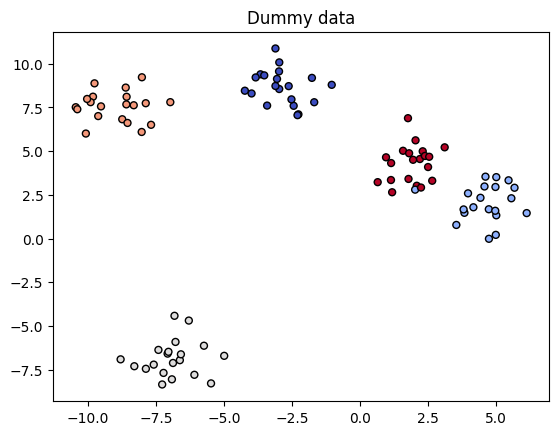

In [39]:
# generate dummy data
points, cluster_membership = make_blobs(
    n_samples=100,
    n_features=2,
    centers=5,
    random_state=42
)

plt.title("Dummy data")
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=25, edgecolor="k", cmap="coolwarm")
plt.show()


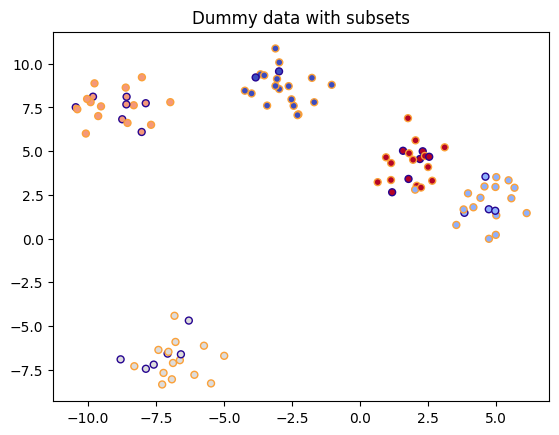

In [40]:
# chosing points to represent two subsets in 1:3 ratio:
subset_membership = np.array([10 if index % 4 == 0 else 200 for index in range(len(points))])

plt.title("Dummy data with subsets")
plt.scatter(points[:, 0], points[:, 1], marker='o',c=cluster_membership, s=25, edgecolor=cmap(subset_membership), cmap="coolwarm")
plt.show()